# «Модель прогнозирования стоимости жилья для агентства недвижимости»

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.


## 1. Постановка задачи  

Цель — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

Техническая задача - разработать небольшой веб-сервис на основе построенной модели, на вход которому поступают данные о недвижимости, на основании которых сервис прогнозирует ее стоимость.

In [71]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import re
import requests

import category_encoders as ce
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from catboost import Pool, CatBoostRegressor
import optuna
import xgboost as xgb
import pickle


import warnings
warnings.filterwarnings('ignore')


## 2. Знакомство с данными, базовый анализ и расширение данных

In [2]:
# читаем исходные данные
df = pd.read_csv('data/data.csv')
data = df.copy()
display(data.head())
display(data.info())

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

None

In [3]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


В данных 377185 строк и 17 столбцов, включая целевой. Все признаки типа object, даже те, что по логике, должны быть числовыми. Из них, на первый взгляд, пропущенных значений нет только в столбцах 'homeFacts', 'schools', 'zipcode' и 'state'. Некоторые столбцы содержат информацию об одном и том же признаке: 'private pool' и 'PrivatePool', 'mls-id' и 'MlsId' - стоит проверить дублируют ли они друг друга.   
При предварительном исследовании внимание также привлекает нулевая площадь ('sqft'),  одно уникальное значение в признаке 'private pool' - наличие бассейна (логично предположить, что должно быть два значения), а также большое количество уникальных значений в признаках 'baths' (229 вариаций ванных? скорее всего разница в написании, то есть необходима обработка), 'beds', 'stories'.  

In [4]:
# для начала найдем и удалим дубликаты
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))


Количество дубликатов: 50
Размер таблицы после удаления дубликатов: (377135, 18)


In [5]:
# в целевом признаке есть пропуски, посмотрим сколько их
print('Пропусков в целевом столбце: {:.2f}%'.format(data.target.isna().mean()*100))
# и удалим их - они не нужны
data = data.dropna(subset=['target'], ignore_index=True)
data.shape

Пропусков в целевом столбце: 0.66%


(374655, 18)

### 2.1. **target**  

Обработаем целевой признак - 'target' (стоимость недвижимости). Приведем его к числовому типу и удалим пропуски.

In [6]:
# исследуем целевой признак
display(data.target.value_counts().index)
import re
# оставляем только цифры
def get_numbers(x):
    """функция удаляет из строки все кроме цифр

    Args:
        x (str): строка

    Returns:
        int: значение в числовом формате
    """
    pattern = '[\D]'
    x = re.sub(pattern, '', x)
    return int(x)


data.target = data.target.apply(get_numbers)
data.target.describe()

Index(['$225,000', '$275,000', '$250,000', '$350,000', '$299,900', '$325,000',
       '$249,900', '$399,000', '$199,900', '$299,000',
       ...
       '425,186', '$620,490+', '$2,284,000', '$390,359', '$458,900+',
       '274,359', '$273,490+', '$645,000+', '$28,272', '$171,306'],
      dtype='object', name='target', length=43939)

count    3.746550e+05
mean     6.447596e+05
std      1.841482e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.820000e+05
max      1.950000e+08
Name: target, dtype: float64

### 2.2. **'baths'**  
К огромному сожалению, данные в этом столбце намного грязнее, чем в предыдущем, поэтому воспользоваться предыдущей формулой не получится. При изучении признака выяснилось, что в столбце содержатся данные вида: 'n Baths', 'n ba', 'Bathroom: n', 'n/n/n', 'n+' и т.д.

In [7]:
# модифицируем функцию
def get_number_of_baths(x):
    """функция принимает на вход строку, если формат строки float пропускает ее,
    в противном случае обрабатывает: удаляет буквы и символы

    Args:
        x (str): строка

    Returns:
        float: очищенное значение в числовом формате
    """
    
    if isinstance(x, float):
        return x
    # обработаем данные вида 'число/число/число'
    elif '/' in x:
        x = x.split('/')[0]
    # заменим неверный разделитель
    elif ',' in x:
        x = x.replace(',', '.')
    # удалим все кроме цифр (таким способом, чтобы не терять точки-разделители)
    pattern = '(\D\.\s)|[a-zA-Z:\+~\-\s\—]'
    x = re.sub(pattern, '', x)
    if x =='':
        x = np.nan    
    return float(x)

data.baths = data.baths.apply(get_number_of_baths)
display(data.baths.describe())
#sns.boxplot(data.baths)

# взглянем на строки с кол-вом ванных 750
display(data[data.baths == 750]['beds'].value_counts())
# 750 ванных в датасете есть (и были до обработки). 
# Поскольку в этих строках также нет адекватных данных в столбце 'beds', 
# будем считать эти данные выбросами и заменим на NaN
data['baths'] = data['baths'].apply(lambda x: np.nan if x==750 else x)
# также заменим на NaN значения больше 100
data['baths'] = data['baths'].apply(lambda x: np.nan if x > 100 else x)

# заполним пропущенные значения, сгруппировав данные по признаку 'beds'
data.baths = data.groupby('beds')['baths'].ffill().bfill()

count    267826.000000
mean          3.383841
std          22.272708
min           0.000000
25%           2.000000
50%           2.500000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

beds
Baths    223
Name: count, dtype: int64

### 2.3. **beds**  



In [8]:
# data.beds.tolist()
# data[data.beds.str.contains('sqft', na= False )]

В столбце есть данные типа '8,637 sqft' и '0.44 acres'. Это явно не количество спален и не их площадь. При исследовании выясняется, что в строках с этими данными также отсутствует информация о ванных. Предполагаю, что это земельные участки без строений. Поэтому подобные данные попробую не удалять, а перенести в столбец с площадью. 

In [9]:
# создадим функцию для извлечения площади 
def get_area(x):
    """функция проверяет строку и если она содержит 'acres' или 'sqft',
    извлекает числовое значение площади

    Args:
        str: строка

    Returns:
        float: числовое значение или NaN
    """
    if isinstance(x, float):
        return x
    # акры переводим в квадратные футы
    elif 'acres' in x:
        x = float(x.split(' ')[0])*43560
    # в некоторых строках вместо числа стоит '--', учтем это
    elif 'sqft' in x and '--' not in x:
        x = float(x.split(' ')[0].replace(',',''))
    else:
        return np.nan
    return x

# создадим временный столбец в датасете, данные из него планируется использовать позже
data['temp_area'] = data.beds.apply(get_area)

# напишем функцию для извлечения числа спален
def get_number_of_beds(x):
    """функция проверяет строку, если float, то пропускает,
    удаляет строки, содержащие единицы площади, 
    в остальных строках удаляет все кроме чисел

    Args:
        x (str): строка 

    Returns:
        float: очищенное значение в числовом формате
    """
    if isinstance(x, float):
        return x
    elif 'acres' in x or 'sqft' in x:
        x = np.nan
        
    # в данных содержится случайный текст, удалим его
    elif len(x.split(' ')) > 10:
        x = np.nan
    else:   
        # удалим все буквы
        pattern = '[^(\d+\.\d+)|(\d+)]' 
        x = re.sub(pattern, '', x)
    
    if x == '':
        x = np.nan
    return float(x)
    
data['beds'] = data.beds.apply(get_number_of_beds)
data['beds'].describe()

count    263604.000000
mean          3.363052
std           1.670044
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         144.000000
Name: beds, dtype: float64

In [10]:
data['beds'].isna().mean()*100
# заполним пропуски, сгруппировав данные по признаку 'baths'
data['beds'] = data.groupby('baths')['beds'].ffill().bfill()
data['beds'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 374655 entries, 0 to 374654
Series name: beds
Non-Null Count   Dtype  
--------------   -----  
374655 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB


### 2.4. **stories**

In [11]:
#data.stories.tolist()

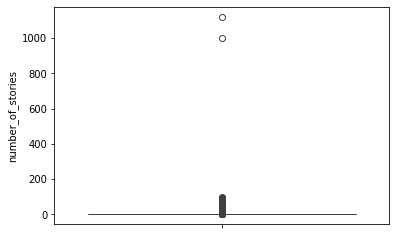

In [12]:
def get_stories(x):
    """функция проверяет строку, если float, то пропускает,
    в противном случае очищает строку от лишних символов

    Args:
        x (str): строка 

    Returns:
        float: очищенное значение в числовом формате
    """
    if isinstance(x, float):
        return x
    # приводим строку к нижнему регистру
    x = x.lower()
    # меняем слова на цифры
    dict_stories = {'one':1, 'two':2, 'three':3, 'four':4}
    for key in dict_stories.keys():
        if key in str(x):
            x =  dict_stories[key]
            
    # для начала убираем из строки буквы
    pattern =  '[a-z]'  
    x = re.sub(pattern, '', str(x))
    # в строках, где этажи указаны через дефис, возьмем только первое значение
    x = x.split('-')[0]
    # в строках, где есть '1/2' (мансарда или чердак), заменим на '0.5'
    if '1/2' in x:
        x=x.replace('1/2', '0.5')
        
    # теперь удалим все оставшиеся символы
    pattern = '[^\d\.]|(\.{2,})'
    x = re.sub(pattern, '', str(x))
    # pattern = '\.{2,}'
    # x = re.sub(pattern, '', str(x))
    
    if x == '':
        x = np.nan
    return float(x)


data['number_of_stories'] = data.stories.apply(get_stories)
sns.boxplot(data['number_of_stories'])

# график показывает два очевидных выброса, заменим их на 0
data['number_of_stories'] = data['number_of_stories'].apply(lambda x: 0 if x >800 else x)
# в этом столбце много пропусков, для начала попробую заполнить их
# сгруппировав данные по признаку 'beds'
data.number_of_stories = data.groupby('beds')['number_of_stories'].ffill().bfill()

### 2.5. **sqft**



In [13]:
# data.sqft.tolist()

в графе sqft: есть данные без разделителя разрядов, данные с разделителем-запятой (НЕ десятичный разделитель), Total interior livable area: 5,266 sqft.

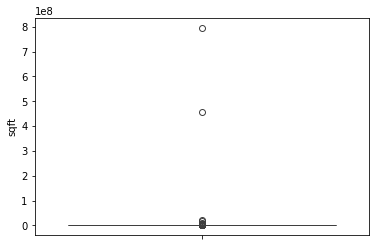

In [14]:
def get_sqft(x):
    """функция проверяет строку, если float, то пропускает,
    в противном случае очищает строку от лишних символов

    Args:
        x (str): строка 

    Returns:
        float: очищенное значение в числовом формате
    """
    if isinstance(x, float):
        return x
    # удаляем все, кроме цифр
    else:
        pattern = '[\D]'
        x = re.sub(pattern, '', str(x))
    
    if x == '':
        x = np.nan
    return float(x)
        
data['sqft'] = data.sqft.apply(get_sqft)
# кроме того у нас есть некоторое кол-во строк с площадью, которые мы вынесли из столбца beds в temp_area
# также добавим их в sqft
ind = data[data.temp_area.notna()].index
data.iloc[ind, 9] = data.iloc[ind, 18]

# поскольку считаем данные в temp_area площадью участков, заполним beds, baths И stories по этим индексам нулями
data.iloc[ind, [4,11,13]] = 0


sns.boxplot(data.sqft)
# удалим слишком сильные выбросы
data = data[data.sqft < 1e6].reset_index().drop('index', axis=1)


### 2.7. **mlsId**  

в данных два столбца с данными об идентификаторах MLS, объединим их в один признак

In [15]:
# объединю данные в третий столбец с удобным названием
data['mls_id'] = data['mls-id'].fillna(data['MlsId'])
# и создадим на его основе признак-мигалку
data['mls_id'] = data['mls_id'].apply(lambda x: 0 if x is np.nan else 1)
data['mls_id'].value_counts()

mls_id
1    298379
0     38146
Name: count, dtype: int64

### **private_pool**  
два столбца с данными о бассейне, так же объединим в один

In [16]:
# так же объединяем данные в один столбец 
data['private_pool'] = data['private pool'].fillna(data['PrivatePool'])
# и создаем признак-мигалку
data['private_pool'] = data['private_pool'].apply(lambda x: 0 if x is np.nan else 1)
data['private_pool'].value_counts()

private_pool
0    292686
1     43839
Name: count, dtype: int64

### 2.8. **fireplace**  
создадим признак-мигалку

In [17]:
# data.fireplace.value_counts().index.tolist()
# создадим признак-мигалку, который показывает наличие камина
def get_fireplace(x):
    """функция проверяет строку, если NaN заменяет на 0,
    в противном случае приводит строку к нижнему регистру,
    заменяет 'no' и 'not' на '0'. Затем строкам, где есть '0', 
    присваивает 0, а остальным - 1.

    Args:
        x (str): строка 

    Returns:
        float: очищенное значение в числовом формате
    """
    if x is np.nan:
        x=0
    else:
        x = str(x).lower()
        pattern = r'(\bno\w*)'
        x = re.sub(pattern, '0', x)

    if '0' in str(x):
        x = 0
    else:
        x = 1
    return x
        
data['has_fireplace'] = data.fireplace.apply(get_fireplace)
data['has_fireplace'].value_counts()

has_fireplace
0    237927
1     98598
Name: count, dtype: int64

### 2.9. **homeFacts**  

этот признак содержит данные в виде словаря со списком словарей, которые нужно десериализовать и исследовать

In [18]:
# data.homeFacts[0]
# пробую перевести строку в словарь через ast  
import ast
temp_df_ast = data.homeFacts.apply(lambda x: ast.literal_eval(x))

# напишем функцию для последующей обработки
def normalize_feature(feature):
    """функция принимает на вход столбец со словарями,
    и возвращает датафрейм, со значениями, распределенными по столбцам 

    Args:
        feature (object): столбец или series со словарями

    Returns:
        df: датафрейм
    """
    # нормализую словарь со списком словарей до нужной степени 
    temp_homefacts = pd.json_normalize(feature)
    temp_homefacts = pd.json_normalize(temp_homefacts['atAGlanceFacts'])
    # создаю список названий колонок
    str_homefacts = temp_homefacts.iloc[0]
    columns = []
    for i in str_homefacts:
        columns.append(i['factLabel'])
    # создаю пустой датафрейм
    df = pd.DataFrame(columns=columns) 
    for i in range(0,7):
        df.iloc[:,i] = pd.json_normalize(temp_homefacts.pop(i)).drop('factLabel', axis=1)
    
    return df

homefacts_data = normalize_feature(temp_df_ast)
# объединяем датасеты (сразу удаляем исходный признак и признак Price/sqft - избавляемся от утечки)
data = pd.concat([data.drop(['homeFacts'], axis=1), homefacts_data.drop(['Price/sqft'], axis=1)], axis=1)
# переименую столбцы в более удобные
data = data.rename(columns={'Year built':'year_built', 'Remodeled year':'remodeled_year',
                            'Heating': 'heating', 'Cooling':'cooling', 'Parking':'parking'}
                   )



2.9.1. Исследуем и обрабатываем получившиеся признаки

In [19]:
# data.year_built.isna().mean()*100
# пропусков в столбце year_built немного, вдобавок они сопровождаются пропусками в других столбцах, так что удалим их
data = data[~data.year_built.isna()].reset_index().drop('index', axis=1)
# в оставшихся столбцах удалим все, кроме цифр
data['year_built'] = data['year_built'].apply(lambda x: re.sub('\D', '', x))
data['year_built'] = data['year_built'].apply(lambda x: 0 if x =='' else x)
# и переведем в числовой тип
data['year_built'] = data['year_built'].astype('int64')


# в признаке 'remodeled_year' нет пропущенных значений, но есть пустые строки и None
# заменим их нулем
data['remodeled_year'] = data.remodeled_year.apply(lambda x: 0 if x == '' or x == None else x)
data['remodeled_year'] = data['remodeled_year'].astype('int')

# признак heating очистим, оставив основные виды отопления
data['heating'] = data.heating.apply(lambda x: x.lower())
def get_heating(x):
    """функция принимает строку, проверяет есть ли в строке значения словаря,
    добавляет в список ключи по найденным значениям и возвращает первое значение в списке.

    Args:
        x (str): строка

    Returns:
        obj: тип отопления
    """
    if x == '':
        x = 'no'
    heating_dict = {'furnace' :['forced air', 'gas', 'air', 'central', 'furnace'],
                'boiler': ['radiant', 'radiators', 'basebord', 'boiler', 'baseboard'],
                'heatpump': ['electricity', 'electric', 'heat pump'],
                'no heating': ['no']
                
                }
    heat_list = []
    for key, value in heating_dict.items():
        for i in value:
            if i in x:
                heat_list.append(key)
                
    if len(heat_list) == 0:
        return 'other'
    else:
        return heat_list[0]
    
data['heating'] = data.heating.apply(get_heating)


# data.cooling.value_counts().index.tolist() - удалю, т.к. во многом дублирует пред столбец
data = data.drop(['cooling'], axis=1)
# data.parking.value_counts().index.tolist()
def get_parking(x):
    x = x.lower()
    match = re.search(r'\bno', x)
    if match is None:
        return 1
    else:
        return 0
    
    
# parking переведем в признак-мигалку    
data['parking'] = data.parking.apply(get_parking)
data['parking'].value_counts()


# lotsize удалю, как дублирующий
data = data.drop(['lotsize'], axis=1)

### 2.10.  **schools**  
десериализовать, обработать

In [20]:
data['schools'] = data['schools'].astype(str)
# поскольку данные в столбце беспорядочны, извлечем рейтинг, используя regex
import re
# оставляем только информацию о рейтинге
data['schools_rating'] = data['schools'].apply(lambda x: re.sub(r'data.*', '', x))
# удаляем '/10'
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'/10', '', x))
# удаляем ненужные символы
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
# удаляем все буквы
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
# удаляем запятые, перед которыми нет цифр
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'\s+,', '', x))
# удаляем запятые и пробел в конце
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-2])
# преобразуем в список
data['schools_rating'] = data['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])


# создадим столбец со средним рейтингом школы
data['schools_rating_ave'] = data['schools_rating'].apply(lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0)
# 0 в столбце 'schools_rating_ave' означает пропущенные значения заполним их средним
data['schools_rating_ave'] = data['schools_rating_ave'].apply(np.round, decimals=2)
average = data['schools_rating_ave'].mean()
data['schools_rating_ave'] = data['schools_rating_ave'].apply(
    lambda x: average if x < 1 else x
)

# создадим признаки с минимальным и максимальным рейтингом школы
data['schools_rating_max'] = data['schools_rating'].apply(lambda x: 0 if len(x) == 0 else max(x))
data['schools_rating_min'] = data['schools_rating'].apply(lambda x: 0 if len(x) == 0 else min(x))


# создадим новую колонку с количеством школ
data['school_count'] = data['schools_rating'].apply(lambda x: (len(x)) if x != '' else 0)
data['school_count'] = data['school_count'].astype('int')


# выделим расстояние до школ
def extract_text(text):
  # извлечем текст между'Distance' и 'Grades'
  pattern = r"Distance': \['(.+?)'\], 'Grades'"
  match = re.search(pattern, text)
  if match:
    # если текст есть, возвращаем его
    return match.group(1)
  else:
    # если нет, возвращаем None
    return None

# создаем столбец 'schools_distance'
data['schools_distance'] = data['schools'].apply(extract_text)
data['schools_distance'] = data['schools_distance'].astype(str)
# удаляем ' mi'
data['schools_distance'] = data['schools_distance'].apply(lambda x: re.sub(r'\smi', '', x))
# удаляем остальные ненужные символы
data['schools_distance'] = data['schools_distance'].str.replace(r'[^\d.,\s]', '', regex=True)
# преобразуем очищенные строки в список чисел
data['schools_distance'] = data['schools_distance'].apply(lambda x: [float(num) for num in x.split(',')] if x else [])

# создаем столбец со средним расстоянием до школ 'schools_distance_ave'
data['schools_distance_ave'] = data['schools_distance'].apply(lambda x: round(sum(x)/len(x), 2) if x else 0)



### 2.11. **'status'**  

необходимо исследовать и привести к стандарту, переименовать сокращения, жаргонизмы, ошибки ввода.

In [21]:
# data.status.value_counts().index.tolist()
data['status'] = data.status.apply(lambda x: x if isinstance(x, float) else x.lower())
# укрупним данные, распределив их по группам
patterns = {  
    re.compile(r'.*auction.*'): 'Auction',
    re.compile(r'c|option contract.*|.*backup.*|accepted|uc|(.*under contract)'): 'Under contract',
    re.compile(r'.*(conting|coming soon|back on market).*'): 'Contingent',
    re.compile(r"pf|pre-foreclosure.*"): 'Pre foreclosure',
    re.compile(r"foreclos*"): 'Foreclosure',
    re.compile(r'new.*'): 'New',
    re.compile(r'.*pending.*|p|active option.'): 'Pending',
    re.compile(r'for sale.*'): 'For sale',
    re.compile(r'due diligence period') : 'Due diligence period',
    re.compile(r'lease/*|.*for rent.*'): 'For rent',
    # re.compile(r'(?i).*Backup.*|Accepted|Uc|U\sUnder\sContract|.*Under.*'): 'Under Contract',
    re.compile(r'.*activ.*|re activated.*'): 'Active'
    }

data['status'] = data['status'].astype(str).apply(
    lambda x: next((replacement for pattern, replacement in patterns.items() if pattern.match(x)), np.nan)
)
data['status'].value_counts()

status
For sale                179557
Active                   89684
Pending                   7199
Foreclosure               6074
New                       5830
Under contract            5077
Auction                   2179
Pre foreclosure           1581
For rent                   389
Contingent                 192
Due diligence period        27
Name: count, dtype: int64

## 2.12. propertyType  

необходимо исследовать и привести к стандарту, переименовать сокращения, жаргонизмы, ошибки ввода.

In [22]:
# переименую колонки для удобства
data = data.rename(columns={'propertyType':'property_type'})

data['property_type'] = data['property_type'].apply(lambda x: x if isinstance(x, float) else x.lower())
# укрупним данные, распределив их по группам
patterns = {  
    re.compile(r'single|detach.*|1\sstory|one story|.*cabin.*|.*bungalow.*|garden home'): 'single-family',
    re.compile(r'multi.*|.*plex|high rise'): 'multi-family',
    re.compile(r'condo.*|condo/unit'): 'condominium',
    re.compile(r'townhouse'): 'townhouse',
    re.compile(r'apartment'): 'apartment',
    re.compile(r'\bland|.*/land'): 'land',
    re.compile(r'.*mobile.*|manufactured'): 'mobile/manufactured',
    re.compile(r'cooperative|coop'): 'cooperative',
    re.compile(r'.*farm.*|.*ranch.*'): 'farms/ranches'
    }

data['property_type'] = data['property_type'].astype(str).apply(
    lambda x: next((replacement for pattern, replacement in patterns.items() if pattern.match(x)), np.nan)
)

# заполним пропуски, сгруппировав данные по признакам 'beds' и 'baths'
data['property_type'] = data.groupby(['beds','baths'])['property_type'].ffill().bfill()
data['property_type'].value_counts()

property_type
single-family          212856
condominium             56124
townhouse               20065
land                    17030
multi-family            15223
cooperative              3686
mobile/manufactured      3682
farms/ranches            3664
apartment                 866
Name: count, dtype: int64

In [23]:
# теперь вернемся к столбцу 'status' и заполним пропуски в нем, сгруппировав данные по 'property_type'
data['status'] = data.groupby('property_type')['status'].ffill().bfill()
data['status'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 333196 entries, 0 to 333195
Series name: status
Non-Null Count   Dtype 
--------------   ----- 
333196 non-null  object
dtypes: object(1)
memory usage: 2.5+ MB


In [24]:
# удалю все ненужные столбцы
data = data.drop(['private pool', 'street', 'fireplace', 'schools', 'zipcode', 'stories',
                  'mls-id', 'PrivatePool', 'MlsId', 'temp_area', 'schools_rating', 'schools_distance'], axis=1)

data.columns


Index(['status', 'property_type', 'baths', 'city', 'sqft', 'beds', 'state',
       'target', 'number_of_stories', 'mls_id', 'private_pool',
       'has_fireplace', 'year_built', 'remodeled_year', 'heating', 'parking',
       'schools_rating_ave', 'schools_rating_max', 'schools_rating_min',
       'school_count', 'schools_distance_ave'],
      dtype='object')

## 3. Разведывательный анализ данных (EDA)

* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы   
* Дополним наш анализ визуализациями, иллюстрирующими исследование. 

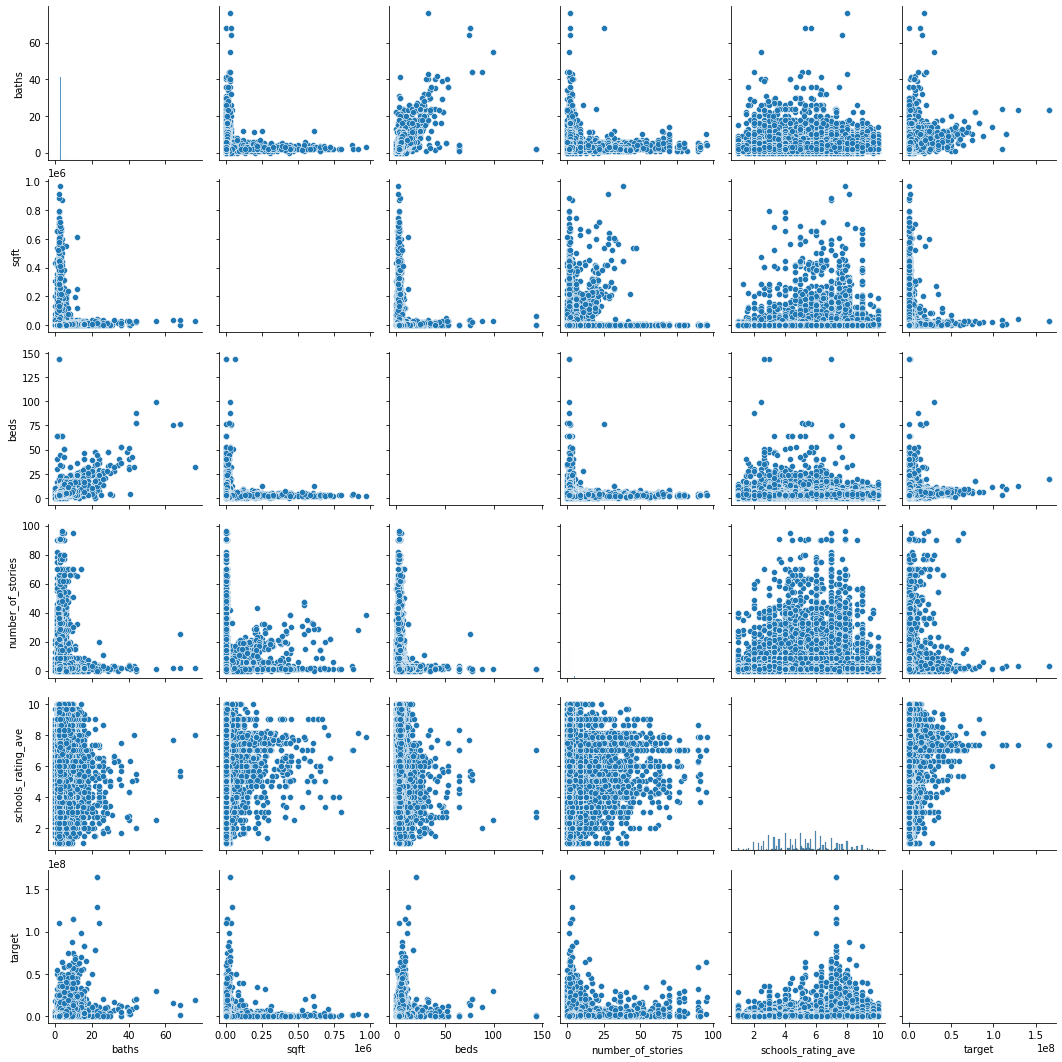

In [25]:
data_for_pairplot = data[['baths', 'sqft', 'beds', 'number_of_stories', 'schools_rating_ave', 'target']]
sns.pairplot(data_for_pairplot)

График практически не показывает распределение признаков. Это говорит нам о том, что 
1. распределение очень далеко от нормального,
2. имеется большое кол-во выбросов.  
Также ожидаемо прослеживается корреляция между количеством спален и ванных.

Исследуем эти признаки ('baths', 'sqft', 'beds', 'number_of_stories', 'target') и попробуем избавиться от выбросов.

### target  
рассмотрим самый важный признак - целевой в разрезе типов недвижимости

*** Результаты теста Шапиро-Уилка ***
p = 0.000
Данные не распределены нормально (мы отвергаем H0)


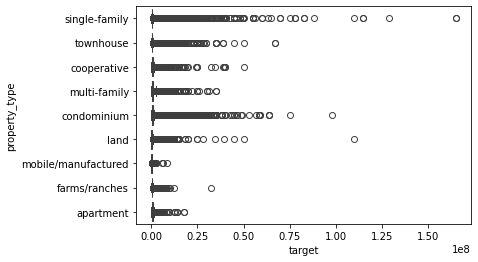

In [26]:
sns.boxplot(y=data['property_type'], x=data['target'], orient='h')
# проведем статистический тест, чтобы проверить гипотезу о нормальности/ненормальности распределения
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака цены
_, p = shapiro(data['target'])
print('*** Результаты теста Шапиро-Уилка ***')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

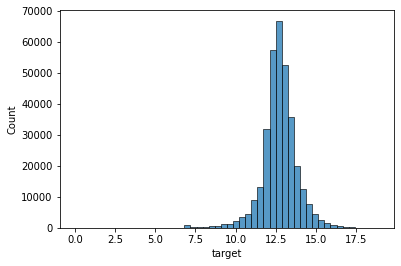

In [27]:
# проверим распределение признака в логарифмическом масштабе
log_target = np.log(data['target']) # min(target) > 0
histplot = sns.histplot(
    data = log_target,
    bins=50,
    );

Исходя из результатов исследований выбросы ищем по методу 3х сигм. Кроме того сдвинем правую границу.

In [28]:
# Функция определения выбросов по методу z-отклонений (трех сигм)
def outliers_z_score(data, feature, log_scale=False, left=3, right=3):
    """функция реализует алгоритм метода z-отклонения.
    На вход она принимает DataFrame и признак, по которому ищутся выбросы.
    и имеет возможность работы в логарифмическом масштабе: 
    если аргумент log_scale равен True, то рассматриваемый признак логарифмируется. 

    Args:
        data (_type_): Датафрейм
        feature (_type_): признак
        log_scale (bool, optional): логарифмирование, по умолчанию False
        left (int): кол-во сигм для нижней границы, по умолчанию = 3
        right (int): кол-во сигм для верхней границы, по умолчанию = 3

    Returns:
        выбросы и очищенный от них датасет
    """
    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if data[feature].min() > 0: # если значения признака больше 0
            x = np.log(data[feature])
        else:
            x = np.log(data[feature]+1) # иначе добавляем единицу
    else:
        x = data[feature]
    
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left* sigma
    upper_bound = mu + right* sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Число выбросов по методу z-отклонений для single-family: 7625
Результирующее число записей для single-family: 205231

Число выбросов по методу z-отклонений для townhouse: 620
Результирующее число записей для townhouse: 19445

Число выбросов по методу z-отклонений для cooperative: 196
Результирующее число записей для cooperative: 3490

Число выбросов по методу z-отклонений для multi-family: 371
Результирующее число записей для multi-family: 14852

Число выбросов по методу z-отклонений для condominium: 2189
Результирующее число записей для condominium: 53935

Число выбросов по методу z-отклонений для land: 337
Результирующее число записей для land: 16693

Число выбросов по методу z-отклонений для mobile/manufactured: 104
Результирующее число записей для mobile/manufactured: 3578

Число выбросов по методу z-отклонений для farms/ranches: 149
Результирующее число записей для farms/ranches: 3515

Число выбросов по методу z-отклонений для apartment: 34
Результирующее число записей для apartme

<Axes: xlabel='target', ylabel='property_type'>

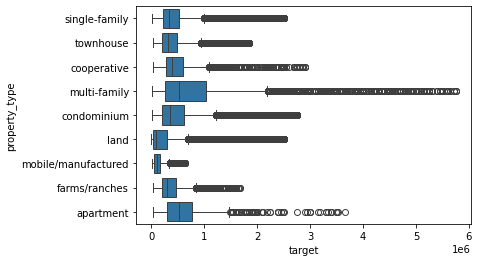

In [29]:
# Создадим списки типов недвижимости ...
property_list = list(data['property_type'].unique())

# Добавим признак выброса в датафрейм и установим нули
data['outliers'] = 0
# В цикле вычислим выбросы для каждого типа недвижимости
for i in property_list:
    outliers, cleaned = outliers_z_score(data=data[data['property_type'] == i],
                                         feature='target',
                                         log_scale=True,
                                         right=2)
    
    print(f'Число выбросов по методу z-отклонений для {i}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {i}: {cleaned.shape[0]}\n')
    
    # Установим флаг выброса в признаке
    data.loc[outliers.index, 'outliers'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {data.outliers.sum()} выбросов.')

# избавляемся от выбросов
data = data[data.outliers == 0].reset_index().drop('index', axis=1)

# снова взглянем на распределение признака по типам недвижимости
sns.boxplot(y=data['property_type'], x=data['target'], orient='h')
# теперь график выглядит более вменяемым

## 'beds'

Число выбросов по методу z-отклонений для single-family: 6542
Результирующее число записей для single-family: 198689

Число выбросов по методу z-отклонений для townhouse: 702
Результирующее число записей для townhouse: 18743

Число выбросов по методу z-отклонений для cooperative: 91
Результирующее число записей для cooperative: 3399

Число выбросов по методу z-отклонений для multi-family: 769
Результирующее число записей для multi-family: 14083

Число выбросов по методу z-отклонений для condominium: 1836
Результирующее число записей для condominium: 52099

Число выбросов по методу z-отклонений для land: 547
Результирующее число записей для land: 16146

Число выбросов по методу z-отклонений для mobile/manufactured: 84
Результирующее число записей для mobile/manufactured: 3494

Число выбросов по методу z-отклонений для farms/ranches: 96
Результирующее число записей для farms/ranches: 3419

Число выбросов по методу z-отклонений для apartment: 32
Результирующее число записей для apartment:

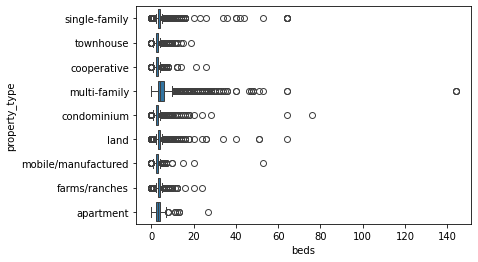

In [30]:
sns.boxplot(y=data['property_type'], x=data['beds'], orient='h')

# Добавим признак выброса в датафрейм и установим нули
data['outliers_beds'] = 0
# В цикле вычислим выбросы для каждого типа недвижимости
for i in property_list:
    outliers, cleaned = outliers_z_score(data=data[data['property_type'] == i],
                                         feature='beds',
                                         log_scale=True,
                                         right=2)
    
    print(f'Число выбросов по методу z-отклонений для {i}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {i}: {cleaned.shape[0]}\n')
    
    # Установим флаг выброса в признаке
    data.loc[outliers.index, 'outliers_beds'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {data.outliers_beds.sum()} выбросов.')

# от выбросов пока избавляться не стану, т.к. хочу проверить совпадают ли они в различных признаках


## baths  


Число выбросов по методу z-отклонений для single-family: 5568
Результирующее число записей для single-family: 199663

Число выбросов по методу z-отклонений для townhouse: 507
Результирующее число записей для townhouse: 18938

Число выбросов по методу z-отклонений для cooperative: 126
Результирующее число записей для cooperative: 3364

Число выбросов по методу z-отклонений для multi-family: 621
Результирующее число записей для multi-family: 14231

Число выбросов по методу z-отклонений для condominium: 1198
Результирующее число записей для condominium: 52737

Число выбросов по методу z-отклонений для land: 670
Результирующее число записей для land: 16023

Число выбросов по методу z-отклонений для mobile/manufactured: 62
Результирующее число записей для mobile/manufactured: 3516

Число выбросов по методу z-отклонений для farms/ranches: 185
Результирующее число записей для farms/ranches: 3330

Число выбросов по методу z-отклонений для apartment: 33
Результирующее число записей для apartmen

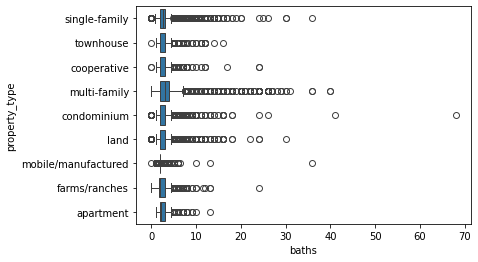

In [31]:
sns.boxplot(y=data['property_type'], x=data['baths'], orient='h')

# Добавим признак выброса в датафрейм и установим нули
data['outliers_baths'] = 0
# В цикле вычислим выбросы для каждого типа недвижимости
for i in property_list:
    outliers, cleaned = outliers_z_score(data=data[data['property_type'] == i],
                                         feature='baths',
                                         log_scale=True,
                                         right=2)
    
    print(f'Число выбросов по методу z-отклонений для {i}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {i}: {cleaned.shape[0]}\n')
    
    # Установим флаг выброса в признаке
    data.loc[outliers.index, 'outliers_baths'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {data.outliers_baths.sum()} выбросов.')

# от выбросов пока избавляться не стану, т.к. хочу проверить совпадают ли они в различных признаках


## 'sqft'

Число выбросов по методу z-отклонений для single-family: 2260
Результирующее число записей для single-family: 202971

Число выбросов по методу z-отклонений для townhouse: 500
Результирующее число записей для townhouse: 18945

Число выбросов по методу z-отклонений для cooperative: 192
Результирующее число записей для cooperative: 3298

Число выбросов по методу z-отклонений для multi-family: 248
Результирующее число записей для multi-family: 14604

Число выбросов по методу z-отклонений для condominium: 828
Результирующее число записей для condominium: 53107

Число выбросов по методу z-отклонений для land: 290
Результирующее число записей для land: 16403

Число выбросов по методу z-отклонений для mobile/manufactured: 32
Результирующее число записей для mobile/manufactured: 3546

Число выбросов по методу z-отклонений для farms/ranches: 161
Результирующее число записей для farms/ranches: 3354

Число выбросов по методу z-отклонений для apartment: 37
Результирующее число записей для apartment

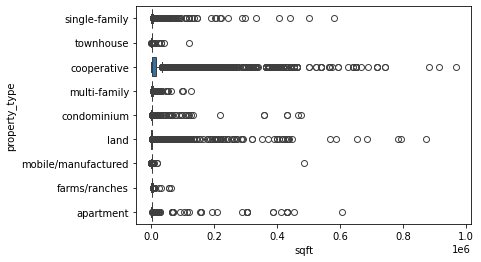

In [32]:
sns.boxplot(y=data['property_type'], x=data['sqft'], orient='h')

# Добавим признак выброса в датафрейм и установим нули
data['outliers_sqft'] = 0
# В цикле вычислим выбросы для каждого типа недвижимости
for i in property_list:
    outliers, cleaned = outliers_z_score(data=data[data['property_type'] == i],
                                         feature='sqft',
                                         log_scale=True,
                                         right=2)
    
    print(f'Число выбросов по методу z-отклонений для {i}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {i}: {cleaned.shape[0]}\n')
    
    # Установим флаг выброса в признаке
    data.loc[outliers.index, 'outliers_sqft'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {data.outliers_sqft.sum()} выбросов.')

# от выбросов пока избавляться не стану, т.к. хочу проверить совпадают ли они в различных признаках

## 'number_of_stories'

Число выбросов по методу z-отклонений для single-family: 2963
Результирующее число записей для single-family: 202268

Число выбросов по методу z-отклонений для townhouse: 239
Результирующее число записей для townhouse: 19206

Число выбросов по методу z-отклонений для cooperative: 105
Результирующее число записей для cooperative: 3385

Число выбросов по методу z-отклонений для multi-family: 228
Результирующее число записей для multi-family: 14624

Число выбросов по методу z-отклонений для condominium: 1328
Результирующее число записей для condominium: 52607

Число выбросов по методу z-отклонений для land: 544
Результирующее число записей для land: 16149

Число выбросов по методу z-отклонений для mobile/manufactured: 135
Результирующее число записей для mobile/manufactured: 3443

Число выбросов по методу z-отклонений для farms/ranches: 95
Результирующее число записей для farms/ranches: 3420

Число выбросов по методу z-отклонений для apartment: 49
Результирующее число записей для apartmen

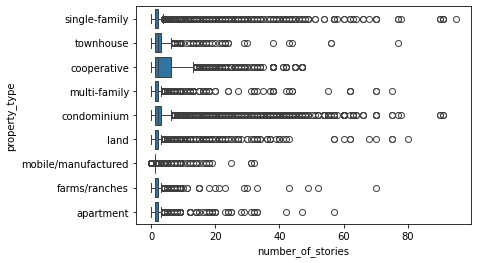

In [33]:
sns.boxplot(y=data['property_type'], x=data['number_of_stories'], orient='h')

# Добавим признак выброса в датафрейм и установим нули
data['outliers_stories'] = 0
# В цикле вычислим выбросы для каждого типа недвижимости
for i in property_list:
    outliers, cleaned = outliers_z_score(data=data[data['property_type'] == i],
                                         feature='number_of_stories',
                                         log_scale=True,
                                         right=2)
    
    print(f'Число выбросов по методу z-отклонений для {i}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {i}: {cleaned.shape[0]}\n')
    
    # Установим флаг выброса в признаке
    data.loc[outliers.index, 'outliers_stories'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {data.outliers_stories.sum()} выбросов.')

# от выбросов пока избавляться не стану, т.к. хочу проверить совпадают ли они в различных признаках

### Обработка найденных выбросов.  
выбросов в признаках очень много, чтобы не потерять данные, попробую заменить их на моду по группе

In [34]:
# beds
for i in property_list:
  mask1 = data['property_type']== i
  mask2 = data['outliers_beds'] == 1
  data.loc[mask1&mask2, 'beds']= data.loc[mask1, 'beds'].mode()[0]

# baths
for i in property_list:
  mask1 = data['property_type']== i
  mask2 = data['outliers_baths'] == 1
  data.loc[mask1&mask2, 'baths']= data.loc[mask1, 'baths'].mode()[0]
  
# sqft
for i in property_list:
  mask1 = data['property_type']== i
  mask2 = data['outliers_sqft'] == 1
  data.loc[mask1&mask2, 'sqft']= data.loc[mask1, 'sqft'].mode()[0]
  
  
# stories
for i in property_list:
  mask1 = data['property_type']== i
  mask2 = data['outliers_stories'] == 1
  data.loc[mask1&mask2, 'number_of_stories']= data.loc[mask1, 'number_of_stories'].mode()[0]


Text(0.5, 1.0, '')

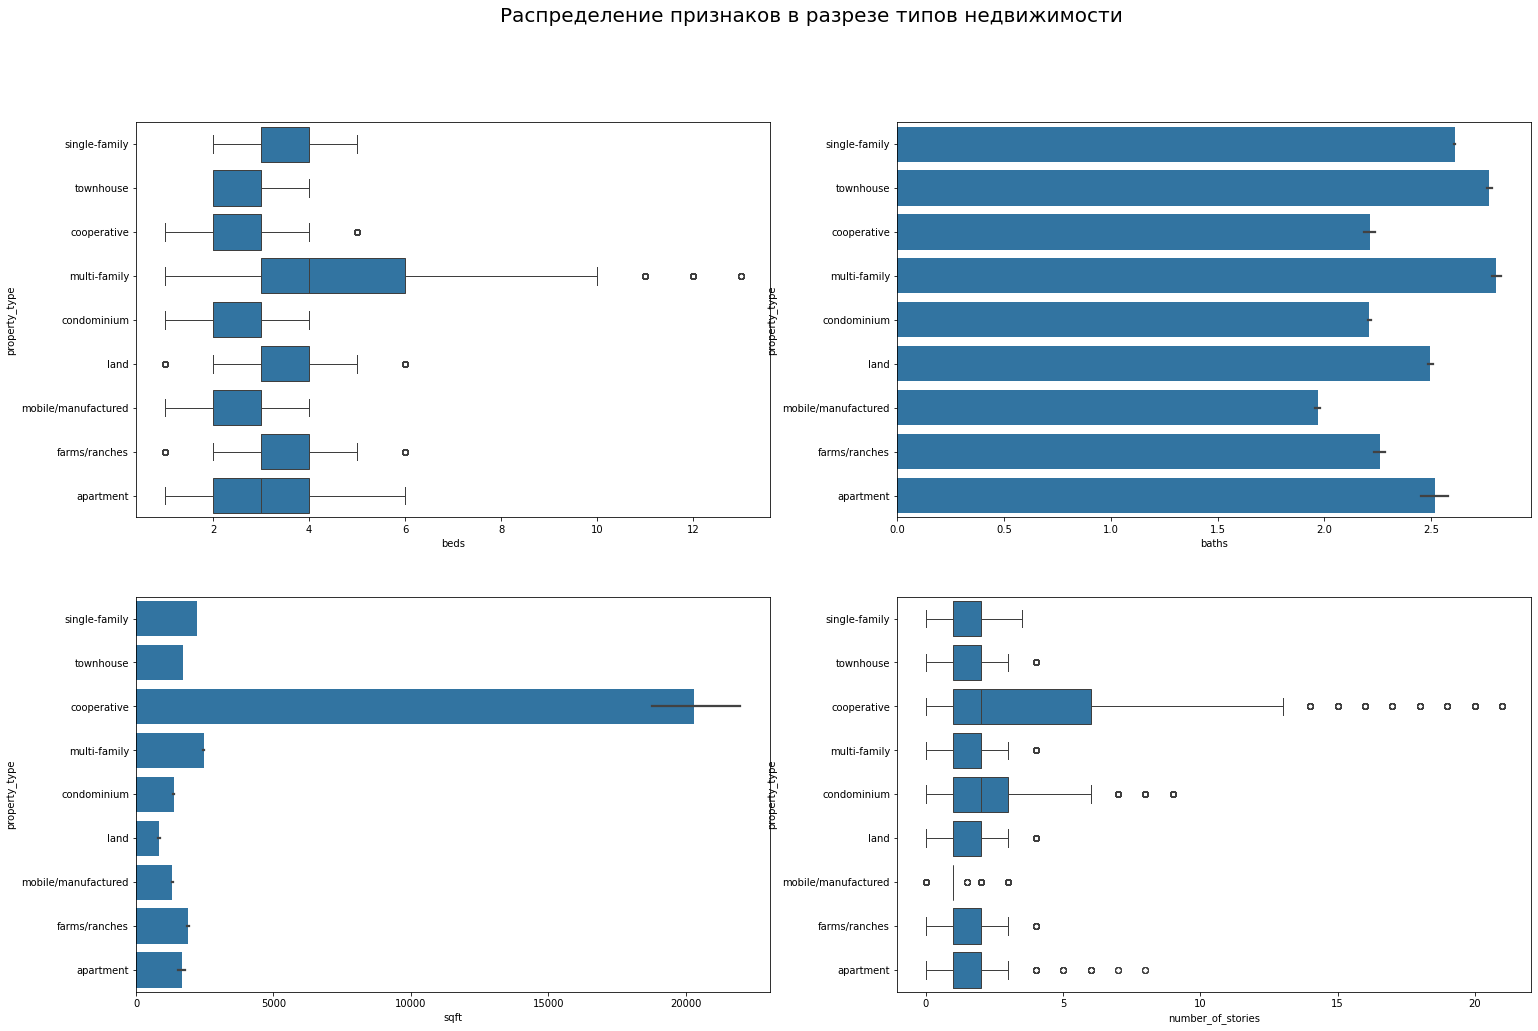

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(25, 16)) #, sharey=True
fig.suptitle('Распределение признаков в разрезе типов недвижимости', fontsize=20)

# beds
sns.boxplot(y=data['property_type'], x=data['beds'],
            orient='h',
            ax=axes[0][0]
            )
axes[0][0].set_title('')

# baths
sns.barplot(y=data['property_type'], x=data['baths'],
            orient='h',
            ax=axes[0][1]
            )
axes[0][1].set_title('')

# sqft
sns.barplot(y=data['property_type'], x=data['sqft'],
            orient='h',
            ax=axes[1][0], 
            )
axes[1][0].set_title('')

# stories
sns.boxplot(y=data['property_type'], x=data['number_of_stories'],
            orient='h',
            ax=axes[1][1]
            )
axes[1][1].set_title('')


Теперь графики выглядят более вменяемо, то есть от самых сильных выбросов мы избавились

In [36]:
#data.isna().mean()*100
# на данном этапе у нас осталось только небольшое кол-во пропусков в столбце city - избавимся от них
data = data[data['city'].notna()].reset_index().drop('index', axis=1)

# Признаки с выбросами уже не нужны - удалим их
data = data.drop(['outliers', 'outliers_beds', 'outliers_baths',
       'outliers_sqft', 'outliers_stories'], axis=1)

## 4. Отбор и преобразование признаков

4.1. В датасете осталось 5 признаков типа object, которые нужно перевести в числовой формат: 'city', 'status', 'property_type', 'heating', 'state', чтобы можно было подавать их в модель.

In [40]:
# признаки  'status', 'property_type', 'heating' закодируем OneHotEncoder
cols = ['status', 'property_type', 'heating']
encoder = OneHotEncoder(sparse=False, drop='first')
onehot_columns = encoder.fit_transform(data[cols])
# объединяем датафреймы
data = pd.concat([data, pd.DataFrame(onehot_columns)], axis=1)
# создаем список имен для переименования новых столбцов
encoded_columns_name = encoder.get_feature_names_out(cols)
# переимовываем столбцы
dict_column_names = {}
for i in range(len(encoded_columns_name)):
    dict_column_names[i] = encoded_columns_name[i]
data.rename(columns=dict_column_names,
          inplace=True)


# признаки 'state', 'city' закодируем BinaryEncoder, т.к. в них много уникальных значений
bin_encoder = ce.BinaryEncoder(cols=['state', 'city']) 
type_bin = bin_encoder.fit_transform(data[['state', 'city']])
data = pd.concat([data, type_bin], axis=1)


In [41]:
# удаляем категориальные признаки
data = data.drop(['city', 'status', 'property_type', 'heating', 'state'], axis=1)

<Axes: >

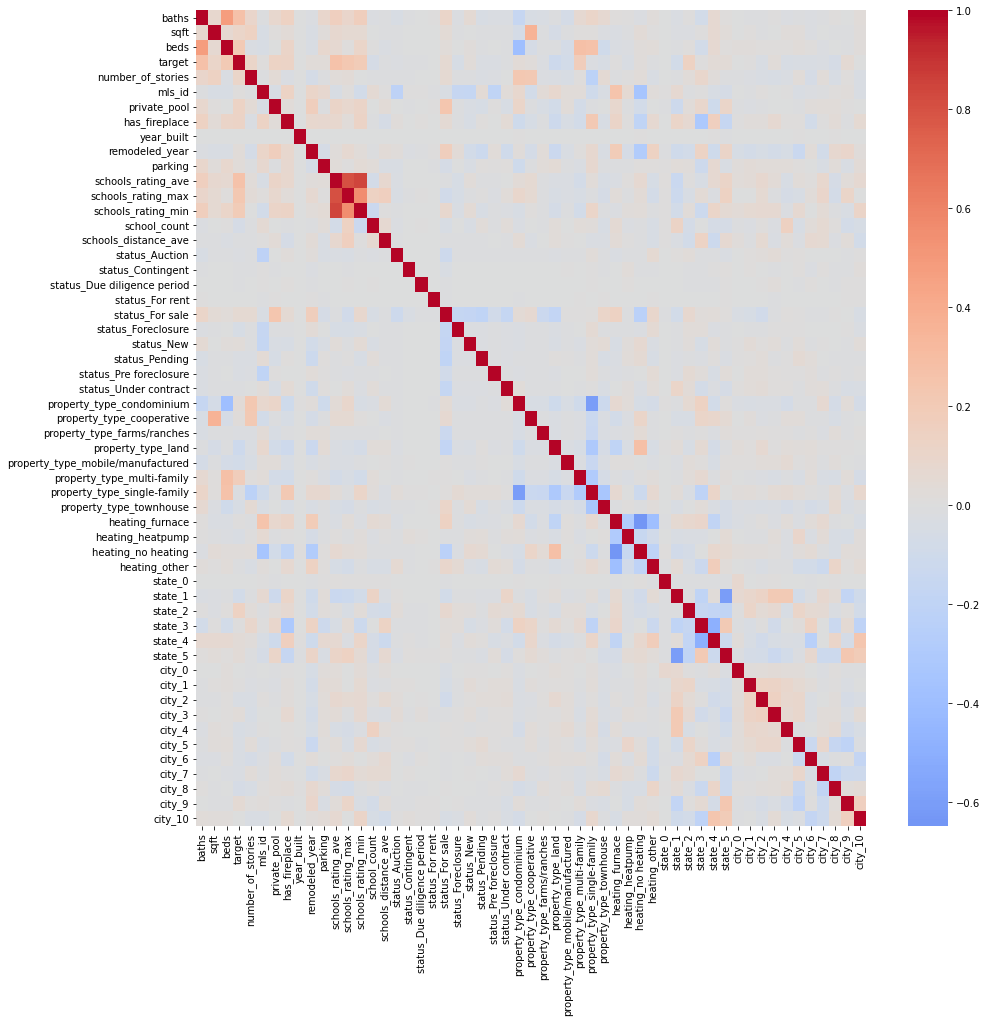

In [42]:
# построим корреляционную матрицу факторов и визуализируем ее
A_corr = data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(), center=0.0, cmap= 'coolwarm') #annot=True

Тепловая карта показала сильную (и ожидаемую) корреляцию между признаками, характеризующими дистанцию до школы. Однако с удалением признаков повременим до дальнейшего анализа

4.2. разделим датасет на тренировочную и тестовую выборки.

In [44]:
random_state=42

In [45]:
X = data.drop(['target'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(225077, 54) (96462, 54) (225077,) (96462,)


In [46]:
# Функция для расчета метрик и вывода на экран
def show_metrics(y_train, y_train_pred, y_test, y_test_pred, precision = 2,
                 show: bool = True) -> tuple:
    """Функция выводит на экран значения метрик MAE, MAPE и R2
    с заданной точностью, а также возвращает их.

    Args:
        y_train : тренировочный вектор ответов
        y_train_pred : тренировочный предсказанный вектор
        y_test : тестовый вектор ответов
        y_test_pred : тестовый предсказанный вектор
        precision : точность округления, по умолчанию = 2
        
    Returns:
        tuple (float): кортеж из 6 метрик 
    """

    # Вычислим метрики и выведем их на экран
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
    r2_test = r2_score(y_test, y_test_pred)
    
    if show: # если флаг вывода на экран установлен
        print('MAE на тренировочной выборке:', round(mae_train, precision))
        print('MAPE на тренировочной выборке:', round(mape_train, precision))
        print('r2 на тренировочной выборке:', round(r2_train,2))

        print('\nMAE на тестовой выборке:', round(mae_test, precision))
        print('MAPE на тестовой выборке:', round(mape_test, precision))
        print('r2 на тестовой выборке:', round(r2_test,2))

    # Вернем вычисленные метрики
    return mae_train, mape_train, r2_train, mae_test, mape_test, r2_test

## Baseline  
обучим baseline-модель на полученном датасете, до преобразования и отбора

In [47]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# И выведем результаты
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочной выборке: 246005.5
MAPE на тренировочной выборке: 117.19
r2 на тренировочной выборке: 0.24

MAE на тестовой выборке: 246821.2
MAPE на тестовой выборке: 119.33
r2 на тестовой выборке: 0.24


На данном этапе модель показывает крайне низкие метрики: MAPE больше 100%, а R^2 - 0.24, то есть модель совершенно не уловила закономерности.


In [48]:
# попробуем нормализовать и стандартизировать данные
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
# кодируем исходный датасет
X_scaled = mm_scaler.fit_transform(X)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# И выведем результаты
print('Результаты на нормализованных данных: ')
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

(225077, 54) (96462, 54) (225077,) (96462,)
Результаты на нормализованных данных: 
MAE на тренировочной выборке: 246005.5
MAPE на тренировочной выборке: 117.19
r2 на тренировочной выборке: 0.24

MAE на тестовой выборке: 246821.2
MAPE на тестовой выборке: 119.33
r2 на тестовой выборке: 0.24


Эксперимент показал, что метрики на нормализованных данных не изменяются

Отбор лучших признаков с помощью SelectKBest

## 5. Тестирование различных моделей

### Линейная регрессия с полиномиальными признаками  
Сгенерируем полиномиальные признаки 2-го порядка, чтобы проверить, сможет ли модель линейной регрессии лучше уловить закономерности в наших данных.

In [50]:
# Создаем объект класса PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

# Генерируем полиномиальные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучим модель линейной регрессии на полиномиальных признаках
poly_model = LinearRegression()
%time poly_model.fit(X_train_poly, y_train)

# Выполним предсказание и выведем результат
y_train_pred = poly_model.predict(X_train_poly)
y_test_pred = poly_model.predict(X_test_poly)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1min 54s
Wall time: 3min 8s
MAE на тренировочной выборке: 177990.62
MAPE на тренировочной выборке: 72.06
r2 на тренировочной выборке: 0.55

MAE на тестовой выборке: 11005835340.28
MAPE на тестовой выборке: 14289856.38
r2 на тестовой выборке: -11114994311413.38


На тренировочных данных модель с полиномиальными признаками показала себя лучше, но на тестовых метрики совершенно неадекватные.

### Дерево решений  
попробуем обучить дерево решений, параметры для него подберем с помощью optuna

In [51]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 10, 20, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = tree.DecisionTreeRegressor(max_depth=max_depth, 
                                     min_samples_leaf=min_samples_leaf,
                                     random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.r2_score(y_train, model.predict(X_train))
  print(f'max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, score: {score}')
  return score

In [52]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="DecisionTreeRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-07-10 09:35:56,659] A new study created in memory with name: DecisionTreeRegressor
[I 2024-07-10 09:36:01,296] Trial 0 finished with value: 0.6334236900233525 and parameters: {'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6334236900233525.


max_depth: 12, min_samples_leaf: 6, score: 0.6334236900233525


[I 2024-07-10 09:36:05,853] Trial 1 finished with value: 0.763839588947615 and parameters: {'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.763839588947615.


max_depth: 17, min_samples_leaf: 7, score: 0.763839588947615


[I 2024-07-10 09:36:10,183] Trial 2 finished with value: 0.7451260603915045 and parameters: {'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.763839588947615.


max_depth: 15, min_samples_leaf: 5, score: 0.7451260603915045


[I 2024-07-10 09:36:14,332] Trial 3 finished with value: 0.7257583019081739 and parameters: {'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.763839588947615.


max_depth: 15, min_samples_leaf: 7, score: 0.7257583019081739


[I 2024-07-10 09:36:18,022] Trial 4 finished with value: 0.5469842224709544 and parameters: {'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.763839588947615.


max_depth: 10, min_samples_leaf: 8, score: 0.5469842224709544


[I 2024-07-10 09:36:22,119] Trial 5 finished with value: 0.6902860116932343 and parameters: {'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.763839588947615.


max_depth: 13, min_samples_leaf: 3, score: 0.6902860116932343


[I 2024-07-10 09:36:25,859] Trial 6 finished with value: 0.5961370204118179 and parameters: {'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.763839588947615.


max_depth: 11, min_samples_leaf: 5, score: 0.5961370204118179


[I 2024-07-10 09:36:30,600] Trial 7 finished with value: 0.8187836188276776 and parameters: {'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8187836188276776.


max_depth: 16, min_samples_leaf: 2, score: 0.8187836188276776


[I 2024-07-10 09:36:34,982] Trial 8 finished with value: 0.6842298130384213 and parameters: {'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8187836188276776.


max_depth: 13, min_samples_leaf: 4, score: 0.6842298130384213


[I 2024-07-10 09:36:39,881] Trial 9 finished with value: 0.722762148676517 and parameters: {'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8187836188276776.


max_depth: 14, min_samples_leaf: 4, score: 0.722762148676517


[I 2024-07-10 09:36:45,217] Trial 10 finished with value: 0.752378598032204 and parameters: {'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.8187836188276776.


max_depth: 19, min_samples_leaf: 10, score: 0.752378598032204


[I 2024-07-10 09:36:50,044] Trial 11 finished with value: 0.8738644867718058 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.8738644867718058.


max_depth: 18, min_samples_leaf: 2, score: 0.8738644867718058


[I 2024-07-10 09:36:54,992] Trial 12 finished with value: 0.8738644867718058 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.8738644867718058.


max_depth: 18, min_samples_leaf: 2, score: 0.8738644867718058


[I 2024-07-10 09:37:00,286] Trial 13 finished with value: 0.9100942760019036 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 20, min_samples_leaf: 2, score: 0.9100942760019036


[I 2024-07-10 09:37:05,597] Trial 14 finished with value: 0.9100942760019036 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 20, min_samples_leaf: 2, score: 0.9100942760019036


[I 2024-07-10 09:37:10,901] Trial 15 finished with value: 0.8769210840673691 and parameters: {'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 20, min_samples_leaf: 3, score: 0.8769210840673691


[I 2024-07-10 09:37:16,130] Trial 16 finished with value: 0.8769210840673691 and parameters: {'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 20, min_samples_leaf: 3, score: 0.8769210840673691


[I 2024-07-10 09:37:21,076] Trial 17 finished with value: 0.752378598032204 and parameters: {'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 19, min_samples_leaf: 10, score: 0.752378598032204


[I 2024-07-10 09:37:25,696] Trial 18 finished with value: 0.8080646995485417 and parameters: {'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 17, min_samples_leaf: 4, score: 0.8080646995485417


[I 2024-07-10 09:37:30,697] Trial 19 finished with value: 0.9100942760019036 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9100942760019036.


max_depth: 20, min_samples_leaf: 2, score: 0.9100942760019036
CPU times: total: 44.7 s
Wall time: 1min 34s


In [53]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем точность для тестовой выборки
model = tree.DecisionTreeRegressor(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Результаты на тестовой выборке: ')
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

Наилучшие значения гиперпараметров {'max_depth': 20, 'min_samples_leaf': 2}
Результаты на тестовой выборке: 
MAE на тренировочной выборке: 71908.56
MAPE на тренировочной выборке: 27.01
r2 на тренировочной выборке: 0.91

MAE на тестовой выборке: 154658.05
MAPE на тестовой выборке: 56.45
r2 на тестовой выборке: 0.53


На текущий момент дерево решений показывает самые лучшие метрики по сравнению с другими моделями. Ошибка снизилась, а охват повысился и на обучающем наборе, и на тестовом. Однако на тестовом наборе метрики значительно хуже, чем на тренировочном, что говорит нам о переобучении.

### Случайный лес  
Дерево решений показало себя неплохо, возможно случайный лес улучшит способности модели.

In [56]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 180, 10)
  max_depth = trial.suggest_int('max_depth', 10, 20, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 15, 1)

  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          n_jobs=-1,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = r2_score(y_train, model.predict(X_train))
  
  print(f'n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, score: {score}')
  
  return score


In [57]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-07-10 09:37:36,953] A new study created in memory with name: RandomForestRegressor
[I 2024-07-10 09:40:27,360] Trial 0 finished with value: 0.7922112858755761 and parameters: {'n_estimators': 130, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7922112858755761.


n_estimators: 130, max_depth: 18, min_samples_leaf: 8, score: 0.7922112858755761


[I 2024-07-10 09:42:09,736] Trial 1 finished with value: 0.6434962814322593 and parameters: {'n_estimators': 110, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7922112858755761.


n_estimators: 110, max_depth: 11, min_samples_leaf: 8, score: 0.6434962814322593


[I 2024-07-10 09:43:56,465] Trial 2 finished with value: 0.7275682184015841 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7922112858755761.


n_estimators: 100, max_depth: 16, min_samples_leaf: 15, score: 0.7275682184015841


[I 2024-07-10 09:47:39,625] Trial 3 finished with value: 0.8274784643220443 and parameters: {'n_estimators': 180, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 180, max_depth: 20, min_samples_leaf: 6, score: 0.8274784643220443


[I 2024-07-10 09:49:55,752] Trial 4 finished with value: 0.8271502815973751 and parameters: {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 110, max_depth: 20, min_samples_leaf: 6, score: 0.8271502815973751


[I 2024-07-10 09:51:32,558] Trial 5 finished with value: 0.6515711778062572 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 100, max_depth: 11, min_samples_leaf: 5, score: 0.6515711778062572


[I 2024-07-10 09:54:50,023] Trial 6 finished with value: 0.8065800579836804 and parameters: {'n_estimators': 160, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 160, max_depth: 17, min_samples_leaf: 6, score: 0.8065800579836804


[I 2024-07-10 09:58:14,309] Trial 7 finished with value: 0.8046350503160655 and parameters: {'n_estimators': 180, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 180, max_depth: 16, min_samples_leaf: 5, score: 0.8046350503160655


[I 2024-07-10 10:00:02,577] Trial 8 finished with value: 0.5928162067162017 and parameters: {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 120, max_depth: 10, min_samples_leaf: 14, score: 0.5928162067162017


[I 2024-07-10 10:03:07,404] Trial 9 finished with value: 0.7695061634064487 and parameters: {'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 11}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 150, max_depth: 19, min_samples_leaf: 11, score: 0.7695061634064487


[I 2024-07-10 10:06:08,196] Trial 10 finished with value: 0.7215677081369027 and parameters: {'n_estimators': 180, 'max_depth': 14, 'min_samples_leaf': 11}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 180, max_depth: 14, min_samples_leaf: 11, score: 0.7215677081369027


[I 2024-07-10 10:08:54,027] Trial 11 finished with value: 0.813516561762248 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 140, max_depth: 20, min_samples_leaf: 7, score: 0.813516561762248


[I 2024-07-10 10:11:56,097] Trial 12 finished with value: 0.790392203076517 and parameters: {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 160, max_depth: 20, min_samples_leaf: 9, score: 0.790392203076517


[I 2024-07-10 10:13:45,517] Trial 13 finished with value: 0.7173785181491661 and parameters: {'n_estimators': 120, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 120, max_depth: 13, min_samples_leaf: 7, score: 0.7173785181491661


[I 2024-07-10 10:16:39,553] Trial 14 finished with value: 0.7738445056954237 and parameters: {'n_estimators': 170, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 170, max_depth: 18, min_samples_leaf: 10, score: 0.7738445056954237


[I 2024-07-10 10:19:09,562] Trial 15 finished with value: 0.827423513948217 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 140, max_depth: 20, min_samples_leaf: 6, score: 0.827423513948217


[I 2024-07-10 10:21:29,982] Trial 16 finished with value: 0.7512770134742948 and parameters: {'n_estimators': 140, 'max_depth': 18, 'min_samples_leaf': 13}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 140, max_depth: 18, min_samples_leaf: 13, score: 0.7512770134742948


[I 2024-07-10 10:23:57,436] Trial 17 finished with value: 0.7850281220209103 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 150, max_depth: 15, min_samples_leaf: 5, score: 0.7850281220209103


[I 2024-07-10 10:26:40,445] Trial 18 finished with value: 0.809668900237372 and parameters: {'n_estimators': 160, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 160, max_depth: 19, min_samples_leaf: 7, score: 0.809668900237372


[I 2024-07-10 10:28:50,922] Trial 19 finished with value: 0.775406204507542 and parameters: {'n_estimators': 130, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8274784643220443.


n_estimators: 130, max_depth: 17, min_samples_leaf: 9, score: 0.775406204507542
CPU times: total: 2h 26min 16s
Wall time: 51min 13s


In [58]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Результаты на тестовой выборке: ')
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

Наилучшие значения гиперпараметров {'n_estimators': 180, 'max_depth': 20, 'min_samples_leaf': 6}
Результаты на тестовой выборке: 
MAE на тренировочной выборке: 98713.46
MAPE на тренировочной выборке: 39.12
r2 на тренировочной выборке: 0.83

MAE на тестовой выборке: 129151.05
MAPE на тестовой выборке: 52.74
r2 на тестовой выборке: 0.71


Случайный лес показал на обучающем наборе метрики несколько хуже, чем дерево решений: MAE и MAPE увеличились, а R^2 снизился с 0,91 до 0,83. Однако метрики на тестовом наборе значительно улучшились: абсолютная и процентная ошибка уменьшились, а охват наоборот возрос с 0,53 до 0,71 и значительно сократилась разница между метриками на тренировочном и тестовом наборах. То есть модель уже не переобучена.  Минус, пожалуй, в очень медленной работе модели (на моем устройстве час на подбор параметров и 12 мин на обучение с лучшими параметрами).

### XGBoost  
Проверим дает ли XGBoost значимое преимущество, параметры подберем также через optuna/

In [67]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 5, 20, 1)
  eta = trial.suggest_float('learning_rate', 0.1, 0.3, step=0.1)


  # создаем модель
  model =  xgb.XGBRegressor(n_estimators=n_estimators,
                        max_depth=max_depth,
                        eta=eta,
                        subsample=0.7,
                        colsample_bytree=0.8,
                        n_jobs=-1,
                        random_state=random_state)
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = r2_score(y_train, model.predict(X_train))
   
  return score


In [68]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="XGBRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-07-10 11:36:26,312] A new study created in memory with name: XGBRegressor
[I 2024-07-10 11:37:45,958] Trial 0 finished with value: 0.9960489655471803 and parameters: {'n_estimators': 177, 'max_depth': 17, 'learning_rate': 0.1}. Best is trial 0 with value: 0.9960489655471803.
[I 2024-07-10 11:39:43,601] Trial 1 finished with value: 0.9993449572859464 and parameters: {'n_estimators': 217, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 1 with value: 0.9993449572859464.
[I 2024-07-10 11:41:23,575] Trial 2 finished with value: 0.9987818428412165 and parameters: {'n_estimators': 127, 'max_depth': 17, 'learning_rate': 0.3}. Best is trial 1 with value: 0.9993449572859464.
[I 2024-07-10 11:43:22,804] Trial 3 finished with value: 0.9991524781089873 and parameters: {'n_estimators': 234, 'max_depth': 16, 'learning_rate': 0.3}. Best is trial 1 with value: 0.9993449572859464.
[I 2024-07-10 11:45:55,828] Trial 4 finished with value: 0.9992580947097657 and parameters: {'n_estimators': 1

CPU times: total: 43min 8s
Wall time: 23min 4s


In [69]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем точность для тестовой выборки
model_xgb = xgb.XGBRegressor(**study.best_params,random_state=random_state, n_jobs=-1)
model_xgb.fit(X_train, y_train)
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
print('Результаты на тестовой выборке: ')
xgb_metrics = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

Наилучшие значения гиперпараметров {'n_estimators': 217, 'max_depth': 20, 'learning_rate': 0.2}
Результаты на тестовой выборке: 
MAE на тренировочной выборке: 561.11
MAPE на тренировочной выборке: 0.45
r2 на тренировочной выборке: 1.0

MAE на тестовой выборке: 114131.45
MAPE на тестовой выборке: 46.34
r2 на тестовой выборке: 0.73


XGBoost показал просто сказочные результаты на тренировочной выборке: процентная ошибка - менее 1 % и стопроцентный охват, что говорит о переобучении. На тестовых данных метрики значительно хуже тренировочных, однако лучше, чем на остальных моделях: абсолютная ошибка - 114131,45, процентная - 46,34, охват - 0,73. Вдобавок она намного быстрее случайного леса. Поэтому эту модель мы используем для продакшена.

## 6. Подготовка модели к продакшену (Preparation for deployment)
С помощью библиотеки Pickle мы сериализуем обученную модель градиентного бустинга и сохраним ее в файл. Его останется только открыть и развернуть на сервере, чтобы выполнять прогнозы стоимости недвижимости.


In [72]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('data/myfile.pkl', 'wb') as output:
    pickle.dump(model_xgb, output)

In [78]:
# Задаем тестовый набор
test_data = [3.5, 2900.0, 4.0, 2.0, 1.0, 0.0, 1.0, 2019.0, 0.0,
             1.0, 5.2, 7.0, 4.0, 5.0, 5.54, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 
             1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 
             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,1.0]
test_data = np.array(test_data).reshape(1, -1) # преобразуем в датафрейм

# Выполняем предсказание с помощью обученной модели
prediction = model_xgb.predict(test_data)

# Выводим результат на экран для проверки при запуске на сервере
print('Такое предсказание должен вернуть сервер:', round(prediction[0]))

Такое предсказание должен вернуть сервер: 788550


## 7. Выводы по проекту  
В ходе выполнения задания были  применены различные методы исследования, очистки и преобразования данных. Знакомство с реальными данными показало, что для этого этапа необходимо много времени и большое разнообразие методов. Также на практике сложнее четко разделить работу на этапы, так как процесс цикличный.   
Были обучены несколько моделей и выбрана показавшая наилучшие результаты - XGBRegressor, эта модель, вдобавок, значительно выигрывает в скорости у других. Почти все модели оказались лучше базовой, модели на основе деревьев справляются с задачей намного лучше, чем простая линейная регрессия.  Метрику R^2 удалось довести до 0,73 (на базовой модели она равнялась 0,24).

